## Import Libraries

In [1]:
import argparse
import matplotlib.pyplot as plt
from plotter_callback import PlotterCallback
import deepxde as dde
import numpy as np
import os
import torch
from scipy.integrate import odeint
from generate_data import get_data
from msfnn import MsFNN

torch.backends.cuda.matmul.allow_tf32 = False
checkpoint_interval = 10_000

# Create the argument parser
# parser = argparse.ArgumentParser()

# # Add the command line argument
# parser.add_argument(
#     "--checkpoint-interval", type=int, help="Interval for saving plots/checkpoints."
# )

# # Parse the arguments
# args = parser.parse_args()

# # Access the value of the command line argument
# checkpoint_interval = args.checkpoint_interval

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Import Data

### Non-dimensionalization
ODE is non-dimensionalized as follows.
Let
$$u = u_cu^*$$
$$t = t_ct^*$$
$$E = E_cE^*$$
Therefore,
$$\frac{du}{dt} = \frac{u_c}{t}\frac{du^*}{dt^*}$$
$$\frac{d^2u}{dt^2} = \frac{u_c}{t^2}\frac{d^2u^*}{dt^{*2}}$$
$$\frac{u_c}{t^2} [M] \frac{d^2u^*}{dt^{*2}} + \frac{u_c}{t} [C] \frac{du^*}{dt^*} + u_c[K]u^* = F\left(t_ct^*\right)$$
$$\iff$$
$$\frac{u_c}{t^2} [M] \frac{d^2u^*}{dt^{*2}} + \frac{u_c}{t} \left( a_0[M] + a_1E_cE^*[K_b] \right) \frac{du^*}{dt^*} + u_cE_cE^*[K_b]u^* = F\left(t_ct^*\right)$$
Further let
$$u_c\equiv \max{u}$$
$$t_c\equiv \max{t}$$
$$E_c\equiv \max{\mathbb{E}}$$
where $\mathbb{E}$ is the space of all reasonable values of $E$. (chosen here to be $10^8$).
Now all network inputs, outputs, and ODE parameters are on the interval $[0,1]$

(4, 290)


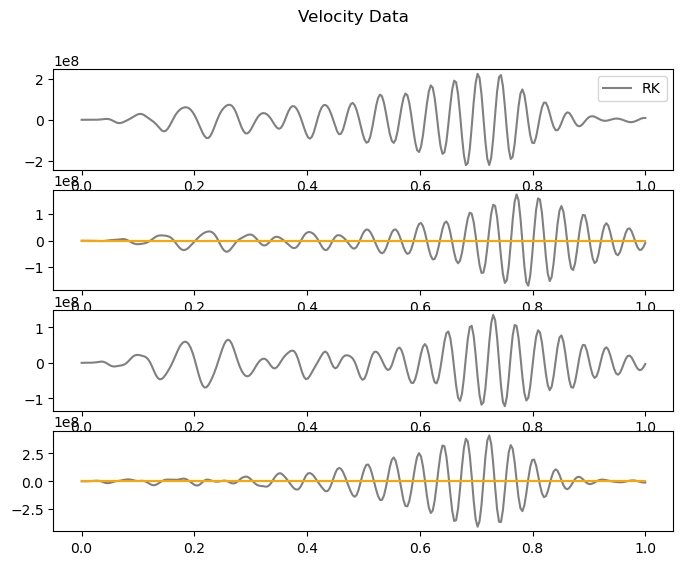

In [2]:
fn = "data"
if not os.path.exists(fn):
    get_data()
dirs = os.listdir(fn)
data = {
    name.split(".")[0]: np.loadtxt(os.path.join(fn, name), max_rows=290)
    for name in dirs
}

# Normalize Data
T_MAX = data["t"].max()
U_MAX = max(data["Disp_3_2D"].max(), data["Disp_4_2D"].max())

data["t"] /= T_MAX
for name in data:
    if "Disp" in name:
        data[name] /= U_MAX
    elif "Vel" in name:
        data[name] *= T_MAX / U_MAX

# For convenience
a0, a1 = data["Damp_param"]

# Get Constant Tensors ready
M = torch.Tensor(data["M"])
Kb = torch.Tensor(data["k_basis"])


# Define interpolation of F. Returns M x N_DIM tensor.
def load(t: torch.Tensor):
    x = t * T_MAX
    xp = data["t"] * T_MAX
    fp = data["load"]
    if isinstance(t, torch.Tensor):
        x = x.detach().cpu().numpy().squeeze()
        f = np.interp(x, xp, fp)
        f = torch.Tensor(f)
        ret = torch.zeros(t.shape[0], 4)
        ret[:, 3] = f
        ret = ret.permute((1, 0))
    else:
        f = np.interp(x, xp, fp).squeeze()
        ret = np.zeros((t.shape[0], 4))
        ret[:, 3] = f
        ret = ret.T
    return ret * 1e3  # convert kN -> N


def scipy_ode(y, t):
    u = y[:4].reshape(-1, 1)
    u_t = y[4:].reshape(-1, 1)

    f = np.zeros((4, 1))
    f = -load(np.array([t]))

    u_tt = (
        T_MAX**2
        / U_MAX
        * np.linalg.inv(data["M"])
        @ (
            f
            - U_MAX / T_MAX * data["C"] @ u_t
            - U_MAX * data["Y"] * data["k_basis"] @ u
        )
    )
    return np.hstack((u_t.squeeze(), u_tt.squeeze())).squeeze()


u0 = np.zeros(8)
sol = odeint(scipy_ode, u0, data["t"]).T[4:]
print(sol.shape)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 6))
for dim in range(4):
    axes = ax[dim]
    axes.plot(data["t"], sol[dim], color="gray", label="RK")
    if dim == 1:
        axes.plot(data["t"], data["Vel_3_2D"], color="orange", label="Data")
    elif dim == 3:
        axes.plot(data["t"], data["Vel_4_2D"], color="orange", label="Data")
    elif dim == 0:
        axes.legend()
fig.suptitle("Velocity Data")
plt.savefig("media/training_data.png", bbox_inches="tight")

## Define the PDE

In [3]:
# Geometry - just an interval
geom = dde.geometry.TimeDomain(data["t"].min(), data["t"].max())


# Helper function
def get_u_derivatives(t: torch.Tensor, u: torch.Tensor) -> tuple[torch.Tensor, ...]:
    u_t, u_tt = [u * 0] * 2
    for dim in range(int(u.shape[1])):
        u_t[:, dim] = dde.grad.jacobian(u, t, i=dim).squeeze()
        u_tt[:, dim] = dde.grad.hessian(u, t, component=dim).squeeze()
    return u_t, u_tt


# Learnable parameter/s
E = dde.Variable(0.1)
# K = dde.Variable(torch.rand((4, 4)))
# K_list = [elem for elem in K.reshape(1, -1).squeeze()]


# ODE definition
def ode_sys(t, u):
    k = Kb * E**2 * 1e8
    F = -load(t)
    C = a0 * M + a1 * k

    y_t, y_tt = get_u_derivatives(t, u)
    y = u.permute((1, 0))
    y_t = y_t.permute((1, 0))
    y_tt = y_tt.permute((1, 0))

    U = y * U_MAX
    DU_DT = y_t * U_MAX / T_MAX
    D2U_DT2 = y_tt * U_MAX / T_MAX**2

    mass_term = torch.mm(M, D2U_DT2)
    damp_term = torch.mm(C, DU_DT)
    stiff_term = torch.mm(k, U)
    force_term = F
    residual = mass_term + damp_term + stiff_term - force_term
    residual = residual.permute((1, 0))
    return residual / 1e5


# Boundary conditions definition
def differentiate_output(t, u, component, order):
    if order == 1:
        return dde.grad.jacobian(u, t, i=component)
    return dde.grad.hessian(u, t, component=component)


t_data = data["t"].reshape(-1, 1)
zero_vector = np.array([[0]])

# IC for unknown dimensions
v0 = [
    dde.icbc.PointSetOperatorBC(
        zero_vector, zero_vector, lambda t, u, X: differentiate_output(t, u, i, 1)
    )
    for i in (0, 1)
]

# Known dimensions
vi = [
    dde.icbc.PointSetOperatorBC(
        t_data,
        data["Vel_3_2D"].reshape(-1, 1),
        lambda t, u, X: differentiate_output(t, u, 1, 1),
    ),
    dde.icbc.PointSetOperatorBC(
        t_data,
        data["Vel_4_2D"].reshape(-1, 1),
        lambda t, u, X: differentiate_output(t, u, 3, 1),
    ),
    # dde.icbc.PointSetOperatorBC(
    #     t_data,
    #     zero_vector,
    #     data["Vel_3_1_2D"].reshape(-1, 1),
    #     lambda t, u, X: differentiate_output(t, u, 0, 1),
    # ),
    # dde.icbc.PointSetOperatorBC(
    #     t_data,
    #     data["Vel_4_1_2D"].reshape(-1, 1),
    #     lambda t, u, X: differentiate_output(t, u, 2, 1),
    # ),
]

# Position BC
xi = [
    dde.icbc.PointSetBC(t_data, data["Disp_3_2D"].reshape(-1, 1), component=1),
    dde.icbc.PointSetBC(t_data, data["Disp_4_2D"].reshape(-1, 1), component=3),
]

pde = dde.data.PDE(
    geom,
    ode_sys,
    vi,
    num_domain=1500,
    num_boundary=2,
)

## Make sure directories exist and are empty

In [4]:
necessary_directories = [["model_files", "checkpoints"], ["plots", "training"]]
folders_created = []
for dir in necessary_directories:
    if not os.path.isdir(dir[0]):
        os.mkdir(dir[0])
        folders_created.append(dir[0])
    if not os.path.isdir(f"{dir[0]}/{dir[1]}"):
        os.mkdir(f"{dir[0]}/{dir[1]}")
        folders_created.append(f"{dir[0]}/{dir[1]}")
print("Created folders:" + "\n> ".join(["", *folders_created]))

## Ensure output files (model_files/checkpoints, plots/training) are empty.
for path in ["/".join(entry) for entry in necessary_directories]:
    print(f"Checking {path}...")
    files = os.listdir(path)
    if not files:
        continue
    print(f"{path} not empty. Deleting contents...")
    for file in files:
        filepath = os.path.join(path, file)
        try:
            os.unlink(filepath)
        except Exception as e:
            print("Failed to delete %s. Reason: %s" % (filepath, e))

if not os.path.exists("out_files"):
    os.mkdir("out_files")

Created folders:
Checking model_files/checkpoints...
Checking plots/training...


## Define the Network

In [5]:
# Callbacks
variable = dde.callbacks.VariableValue(var_list=E, period=checkpoint_interval, filename="out_files/variables.dat")

plotter_callback = PlotterCallback(
    period=checkpoint_interval, 
    filepath="plots/training", 
    data=data,
    E_learned=E,
    t_max=T_MAX, 
    u_max=U_MAX, 
    plot_residual=False
)

resampler = dde.callbacks.PDEPointResampler(period=1_000)


## Create, Compile, and Train Network

In [6]:
net = MsFNN(
    layer_sizes=[1] + 5*[100] + [4],
    activation="tanh",
    kernel_initializer="Glorot uniform",
    sigmas=[1, 10, 50]
)

model = dde.Model(pde, net)

model.compile(optimizer="L-BFGS")
model.restore("model_files/msfnn-65000.pt")

Compiling model...
'compile' took 0.000663 s



[tensor(0.1000, requires_grad=True)]

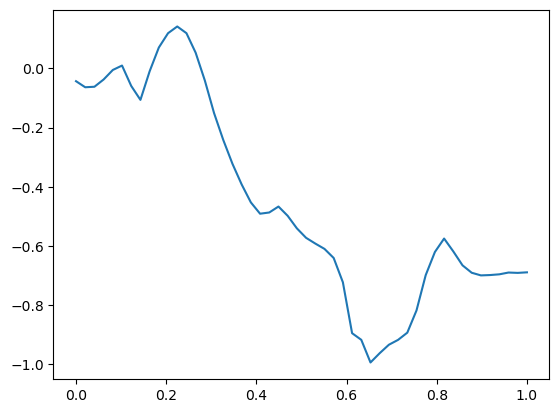

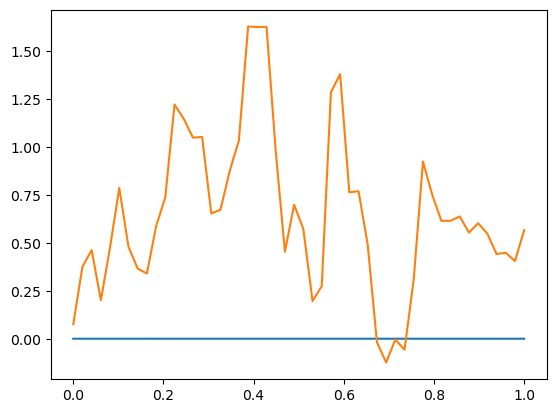

In [7]:
t = np.linspace(0, 1).reshape(-1, 1)
u = model.predict(t)

plt.figure()
plt.plot(t, u[:, 0])
plt.figure()
plt.plot(data['t'], data['Disp_3_2D'])
plt.plot(t, u[:, 1])

model.external_trainable_variables